# Experiments

## Imports

In [1]:
import jax 
import jax.numpy as jnp
import optax 
from jax import config 
config.update("jax_enable_x64", True)

import backward_ica.hmm as hmm
import backward_ica.utils as utils
from backward_ica.svi import SVITrainer

## Common setup

In [2]:
seed_model_params = 1326 # one seed for the true model
seed_infer = 4569 # one seed for the approximating models 

num_fits = 5 # number of starting points for the optimisation of variational models
state_dim, obs_dim = 1,1 
seq_length = 64 # length of each training sequence
num_seqs = 4096 # number of sequences in the training set

batch_size = 64 # here a batch is a group of sequences 
learning_rate = 1e-2
num_epochs = 150
num_batches_per_epoch = num_seqs // batch_size
optimizer = optax.adam(learning_rate=learning_rate)
num_samples = 1 # number of samples for the monte carlo approximation of the expectation of the (possibly nonlinear) emission term

## Linear case

In [3]:
key = jax.random.PRNGKey(seed_model_params)
infer_key = jax.random.PRNGKey(seed_infer)

### Define true model, get samples and compute reference likelihood via Kalman

In [4]:
p = hmm.LinearGaussianHMM(state_dim=state_dim, 
                        obs_dim=obs_dim, 
                        transition_matrix_conditionning='diagonal') # specify the structure of the true model
                        
key, subkey = jax.random.split(key, 2)
p_params = p.get_random_params(subkey) # sample params randomly (but covariances are fixed to default values)

key, subkey = jax.random.split(key, 2)
state_seqs, obs_seqs = hmm.sample_multiple_sequences(subkey, p.sample_seq, p_params, num_seqs, seq_length)

evidence_seq = jax.vmap(lambda obs_seq: p.likelihood_seq(obs_seq, p_params))(obs_seqs)
avg_evidence_kalman = jnp.mean(evidence_seq)
print('Avg evidence given by Kalman:', avg_evidence_kalman)

Avg evidence given by Kalman: 97.63496261673498


### Define and fit the variational model

End of fit 1/5, final ELBO 97.243
End of fit 2/5, final ELBO 97.490
End of fit 3/5, final ELBO 95.576
End of fit 4/5, final ELBO 97.412
End of fit 5/5, final ELBO 97.611
Best fit is 5
Kalman MSE averaged across all sequences: 0.0020152314371017143
Backward variational MSE averaged across all sequences: 0.0020556239309302573


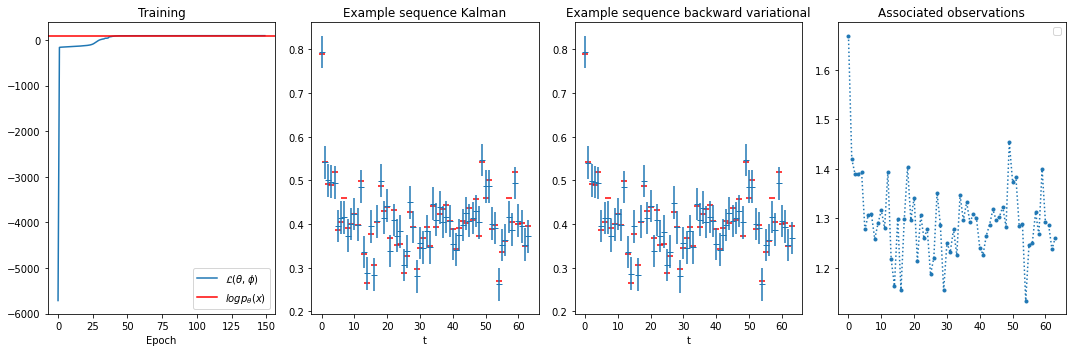

In [5]:
q = hmm.LinearGaussianHMM(state_dim=state_dim, 
                        obs_dim=obs_dim, 
                        transition_matrix_conditionning='diagonal') # specify the structure of the true model, but init params are sampled during optimisiation     

trainer = SVITrainer(p, q, optimizer, num_epochs, batch_size, num_samples)

q_params, avg_elbos = trainer.multi_fit(obs_seqs, p_params, infer_key, num_fits=num_fits) # returns the best fit (based on the last value of the elbo)
utils.plot_fit_results_1D_against_reference(p, q, p_params, q_params, state_seqs, obs_seqs, avg_elbos, avg_evidence_kalman)

## Nonlinear case

In [6]:
# we get the same random keys therefore the transition kernel is identical to the one in the linear case
key = jax.random.PRNGKey(seed_model_params)
infer_key = jax.random.PRNGKey(seed_infer)
num_particles = 100 # number of particles for the smc runs

### Define true model, get samples, and compute reference likelihood via bootstrap SMC

In [7]:
p = hmm.NonLinearGaussianHMM(state_dim=state_dim, 
                        obs_dim=obs_dim, 
                        transition_matrix_conditionning='diagonal') # the emission map is a fully connected neural network with 8 neurons in the hidden layer

key, subkey = jax.random.split(key, 2)
p_params = p.get_random_params(subkey)

key, subkey = jax.random.split(key, 2)
state_seqs, obs_seqs = hmm.sample_multiple_sequences(subkey, p.sample_seq, p_params, num_seqs, seq_length)



prior_key, resampling_key, proposal_key = jax.random.split(key, 3)
prior_keys = jax.random.split(prior_key, num_seqs * num_particles).reshape(num_seqs, num_particles, -1)
resampling_keys = jax.random.split(resampling_key, num_seqs * (seq_length - 1)).reshape(num_seqs, seq_length - 1, -1)
proposal_keys = jax.random.split(proposal_key, num_seqs * (seq_length - 1)).reshape(num_seqs, seq_length - 1, -1)


likel_smc = lambda obs_seq, prior_keys, resampling_keys, proposal_keys: p.likelihood_seq(obs_seq, prior_keys, resampling_keys, proposal_keys, p_params, num_particles)

avg_evidence_smc = jnp.mean(jax.vmap(likel_smc)(obs_seqs, prior_keys, resampling_keys, proposal_keys))
print('Avg evidence given by SMC', avg_evidence_smc)

Avg evidence given by SMC 79.1269775042191


### Define and fit a linear variational model

End of fit 1/5, final ELBO -343.250
End of fit 2/5, final ELBO -325.485
End of fit 3/5, final ELBO -819218.383
End of fit 4/5, final ELBO -496.276
End of fit 5/5, final ELBO -489.649
Best fit is 2
Backward variational MSE averaged across all sequences: 0.04186346674322007


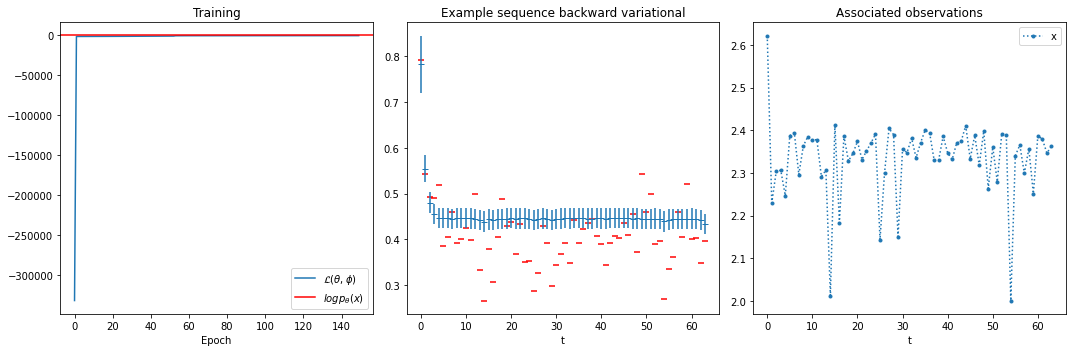

In [8]:
q = hmm.LinearGaussianHMM(state_dim, obs_dim, 'diagonal')

trainer = SVITrainer(p, q, optimizer, num_epochs, batch_size, num_samples)

q_params, avg_elbos = trainer.multi_fit(obs_seqs, p_params, infer_key, num_fits=num_fits)

print('Backward variational MSE averaged across all sequences:', utils.smoothing_results_mse(state_seqs, obs_seqs, q, q_params))
# print('SMC MSE averaged across all sequences:', utils.smoothing_results_mse_with_aux(state_seqs, obs_seqs, p, p_params, prior_keys, resampling_keys, proposal_keys, num_particles))


utils.plot_fit_results_1D(q, q_params, state_seqs, obs_seqs, avg_elbos, avg_evidence_smc, 0)

### Define and fit a nonlinear variational model with filtering and backward updates given by neural networks

In [9]:
example_states = jnp.arange(0,100) / 100 
p.emission_kernel.map(example_states.reshape((100,1)), p.format_params(p_params).emission)

DeviceArray([[-8.46970667e-01],
             [-7.59072817e-01],
             [-6.65294238e-01],
             [-5.65990887e-01],
             [-4.61572067e-01],
             [-3.52497032e-01],
             [-2.39270882e-01],
             [-1.22439791e-01],
             [-2.58563046e-03],
             [ 1.19679943e-01],
             [ 2.43721856e-01],
             [ 3.68888353e-01],
             [ 4.94517997e-01],
             [ 6.19946824e-01],
             [ 7.44515564e-01],
             [ 8.67576789e-01],
             [ 9.88501899e-01],
             [ 1.10668784e+00],
             [ 1.22156341e+00],
             [ 1.33259514e+00],
             [ 1.43929258e+00],
             [ 1.54121296e+00],
             [ 1.63796510e+00],
             [ 1.72921268e+00],
             [ 1.81467662e+00],
             [ 1.89413670e+00],
             [ 1.96743233e+00],
             [ 2.03446257e+00],
             [ 2.09518535e+00],
             [ 2.14961590e+00],
             [ 2.19782452e+00],
        

End of fit 1/5, final ELBO -818232.816
End of fit 2/5, final ELBO nan
End of fit 3/5, final ELBO -502.294
End of fit 4/5, final ELBO -433.492
End of fit 5/5, final ELBO -484.994
Best fit is 4
Backward variational MSE averaged across all sequences: 0.03537220785964438


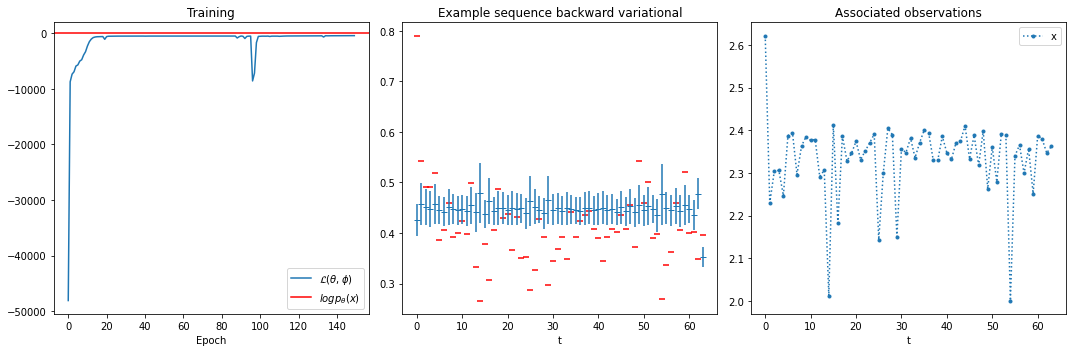

In [10]:
q = hmm.NeuralBackwardSmoother(state_dim=state_dim, 
                        obs_dim=obs_dim) # this is a combination of three fully connected neural networks to update the backward and filtering distributions, as well a prior parameter and a shared parameter

trainer = SVITrainer(p, q, optimizer, num_epochs, batch_size, num_samples)

q_params, avg_elbos = trainer.multi_fit(obs_seqs, p_params, infer_key, num_fits=num_fits)

print('Backward variational MSE averaged across all sequences:', utils.smoothing_results_mse(state_seqs, obs_seqs, q, q_params))

utils.plot_fit_results_1D(q, q_params, state_seqs, obs_seqs, avg_elbos, avg_evidence_smc, 0)